# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**




In [1]:
import random
import os, time, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.amp import GradScaler, autocast
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

## **Configurazione + Device**

In [2]:
@dataclass
class Config:
    # paths
    data_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset"
    #data_dir: str = "/kaggle/input/visual-exam-dataset-2/visual_dataset"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test"

    model_name: str = "efficientnet_b0"
    
    # training
    batch_size: int = 64
    epochs: int = 50
    lr: float = 3e-4
    weight_decay: float = 3e-4
    num_workers: int = 4

    # early stopping
    patience: int = 3
    min_delta: float = 1e-3
    monitor: str = "val_loss"  # "val_loss" or "val_f1"
    best_path: str = "best_effb0_scratch.pth"

    # loss / regularization
    label_smoothing: float = 0.1

    # mixup
    mixup_alpha: float = 0.2
    mixup_prob: float = 0.5

    # model
    se_reduction: int = 16


def get_device() -> torch.device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sanity_check_paths(cfg: Config):
    if not os.path.exists(cfg.data_dir):
        raise FileNotFoundError(f"Train/Val root not found: {cfg.data_dir}")
    print(f"Dataset root: {cfg.data_dir}")
    print(f"Folders found: {os.listdir(cfg.data_dir)}")

    if not os.path.exists(cfg.test_dir):
        print(f"WARNING: Test dir not found: {cfg.test_dir}")
    else:
        print(f"Test dir: {cfg.test_dir}")

## **Preprocessing + Data Augmentation**

In [3]:
class GrayWorldWB:
    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0, 1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / (arr.max() + 1e-6)
        return Image.fromarray((arr * 255).astype(np.uint8))


class AutoContrast:
    def __call__(self, img: Image.Image) -> Image.Image:
        return ImageOps.autocontrast(img, cutoff=1)


def build_transforms() -> Dict[str, transforms.Compose]:
    preprocess = transforms.Compose([
        GrayWorldWB(),
        AutoContrast(),
    ])

    train_tf = transforms.Compose([
        preprocess,
        transforms.RandomResizedCrop(224, scale=(0.4, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.15),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.2),
        transforms.RandomApply([transforms.RandomAdjustSharpness(sharpness_factor=2)], p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
    ])

    val_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    return {"train": train_tf, "val": val_tf}


def build_test_transforms() -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

## **Dataset + DataLoader**

In [4]:
def build_datasets(cfg: Config, tfs: Dict[str, transforms.Compose]):
    train_ds = datasets.ImageFolder(os.path.join(cfg.data_dir, "train"), tfs["train"])
    val_ds   = datasets.ImageFolder(os.path.join(cfg.data_dir, "valid"), tfs["val"])

    class_names = train_ds.classes
    num_classes = len(class_names)

    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_ds)}")
    print(f"Validation samples: {len(val_ds)}")

    return {"train": train_ds, "val": val_ds}, class_names, num_classes


def build_dataloaders(cfg: Config, device: torch.device, dsets):
    pin_memory = (device.type == "cuda")
    persistent = (cfg.num_workers > 0)

    dl_kwargs = dict(
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent,
    )
    if persistent:
        dl_kwargs["prefetch_factor"] = 2

    dls = {
        "train": DataLoader(dsets["train"], shuffle=True,  **dl_kwargs),
        "val":   DataLoader(dsets["val"],   shuffle=False, **dl_kwargs),
    }
    sizes = {"train": len(dsets["train"]), "val": len(dsets["val"])}
    return dls, sizes


## **Modello EfficientNetB0 senza pesi**

In [5]:
def build_efficientnet_b0(num_classes: int, device: torch.device) -> nn.Module:
    # IMPORTANT: niente pesi pretrained
    model = models.efficientnet_b0(weights=None)

    # sostituisci classifier finale
    # EfficientNet in torchvision ha model.classifier = Sequential(Dropout, Linear)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model.to(device)


def build_amp_scaler(device: torch.device) -> GradScaler:
    return GradScaler(enabled=(device.type == "cuda"))

## **Mixup Utils**

In [6]:
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam


def one_hot(labels, num_classes, device):
    return F.one_hot(labels, num_classes=num_classes).float().to(device)


def soft_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

## **Training (early stop + metriche)**

In [7]:
def train_model(
    model: nn.Module,
    dataloaders: Dict[str, DataLoader],
    dataset_sizes: Dict[str, int],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler,
    device: torch.device,
    cfg: Config,
    scaler: Optional[GradScaler],
    num_classes: int
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1

    if cfg.monitor not in ("val_loss", "val_f1"):
        raise ValueError("monitor must be 'val_loss' or 'val_f1'")

    if cfg.monitor == "val_loss":
        best_metric = float("inf")
        mode = "min"
    else:
        best_metric = -float("inf")
        mode = "max"

    epochs_no_improve = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch}/{cfg.epochs - 1}")
        print("-" * 10)

        epoch_stats = {}

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            seen = 0

            all_preds = []
            all_targets = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):

                    # MixUp SOLO in train
                    use_mixup = (phase == "train" and np.random.rand() < cfg.mixup_prob)
                    if use_mixup:
                        inputs_mix, y_a, y_b, lam = mixup_data(inputs, labels, alpha=cfg.mixup_alpha)
                        soft_targets = lam * one_hot(y_a, num_classes, device) + (1 - lam) * one_hot(y_b, num_classes, device)

                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs_mix)
                            loss = soft_cross_entropy(outputs, soft_targets)

                        _, preds = torch.max(outputs, 1)

                        # accuracy pesata (logging)
                        correct_a = (preds == y_a).float().sum().item()
                        correct_b = (preds == y_b).float().sum().item()
                        batch_corrects = lam * correct_a + (1 - lam) * correct_b

                        hard_targets_for_f1 = y_a  # indicativo
                    else:
                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        batch_corrects = (preds == labels).float().sum().item()
                        hard_targets_for_f1 = labels

                    if phase == "train":
                        if scaler is not None and device.type == "cuda":
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += batch_corrects
                seen += bs

                all_preds.append(preds.detach().cpu().numpy())
                all_targets.append(hard_targets_for_f1.detach().cpu().numpy())

            if phase == "train" and scheduler is not None:
                scheduler.step()

            denom = max(1, seen)
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects / denom

            all_preds = np.concatenate(all_preds) if all_preds else np.array([], dtype=np.int64)
            all_targets = np.concatenate(all_targets) if all_targets else np.array([], dtype=np.int64)
            epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0) if all_targets.size else 0.0

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1(macro): {epoch_f1:.4f}")

            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc
            epoch_stats[f"{phase}_f1"] = epoch_f1

        # history
        for k in history.keys():
            history[k].append(epoch_stats[k])

        # early stopping
        current = epoch_stats[cfg.monitor]

        improved = (best_metric - current) > cfg.min_delta if mode == "min" else (current - best_metric) > cfg.min_delta

        if improved:
            best_metric = current
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), cfg.best_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= cfg.patience:
            print(f"Early stopping at epoch {epoch} (best {cfg.monitor} at epoch {best_epoch}: {best_metric:.6f})")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best {cfg.monitor}: {best_metric:.6f} at epoch {best_epoch}")

    model.load_state_dict(best_model_wts)
    return model, history

## **Plot delle curve**

In [8]:
def plot_history(history: Dict[str, List[float]]):
    epochs_range = range(len(history["train_loss"]))
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train Acc")
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["train_f1"], label="Train Macro-F1")
    plt.plot(epochs_range, history["val_f1"], label="Val Macro-F1")
    plt.title("Macro-F1")
    plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

## **Evaluation su test + Matrice di confusione**

In [9]:
def build_test_loader(cfg: Config, device: torch.device):
    if not os.path.exists(cfg.test_dir):
        raise FileNotFoundError(f"Test directory not found at {cfg.test_dir}")

    test_tf = build_test_transforms()
    test_ds = datasets.ImageFolder(cfg.test_dir, transform=test_tf)

    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=(device.type == "cuda"),
    )

    print(f"Test samples found: {len(test_ds)}")
    print(f"Classes found: {len(test_ds.classes)}")
    return test_ds, test_loader


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    return acc, f1, all_targets, all_preds


def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix (normalized)"):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 100):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")

## **Main**

In [10]:
cfg = Config()
set_seed(42) 
device = get_device()
sanity_check_paths(cfg)

Using device: cuda
Dataset root: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset
Folders found: ['test_degradato', 'sports_labels.csv', 'valid', 'test', 'train']
Test dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test


In [11]:
tfs = build_transforms()           
dsets, class_names, num_classes = build_datasets(cfg, tfs)
dls, sizes = build_dataloaders(cfg, device, dsets)

Number of classes: 100
Training samples: 19100
Validation samples: 500


In [12]:
model = build_efficientnet_b0(num_classes=num_classes, device=device)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

optimizer = optim.AdamW(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=cfg.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cfg.epochs
)

scaler = build_amp_scaler(device)

print(model.classifier)  # non model.fc
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)
Trainable params: 4135648


In [13]:
model, history = train_model(
    model=model,
    dataloaders=dls,
    dataset_sizes=sizes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    cfg=cfg,
    scaler=scaler,
    num_classes=num_classes
)

Epoch 0/49
----------
train Loss: 4.4277 Acc: 0.0303 F1(macro): 0.0193
val Loss: 4.0271 Acc: 0.0720 F1(macro): 0.0345
Epoch 1/49
----------
train Loss: 3.9817 Acc: 0.0872 F1(macro): 0.0608
val Loss: 3.6683 Acc: 0.1560 F1(macro): 0.1123
Epoch 2/49
----------
train Loss: 3.6550 Acc: 0.1516 F1(macro): 0.1093
val Loss: 3.2313 Acc: 0.2700 F1(macro): 0.2190
Epoch 3/49
----------
train Loss: 3.3832 Acc: 0.2118 F1(macro): 0.1535
val Loss: 2.8625 Acc: 0.3780 F1(macro): 0.3405
Epoch 4/49
----------
train Loss: 3.2269 Acc: 0.2531 F1(macro): 0.1928
val Loss: 2.7144 Acc: 0.4120 F1(macro): 0.3687
Epoch 5/49
----------
train Loss: 2.9422 Acc: 0.3179 F1(macro): 0.2397
val Loss: 2.5041 Acc: 0.4800 F1(macro): 0.4481
Epoch 6/49
----------
train Loss: 2.8115 Acc: 0.3596 F1(macro): 0.2769
val Loss: 2.4515 Acc: 0.4920 F1(macro): 0.4669
Epoch 7/49
----------
train Loss: 2.7015 Acc: 0.3886 F1(macro): 0.3057
val Loss: 2.2591 Acc: 0.5420 F1(macro): 0.5200
Epoch 8/49
----------
train Loss: 2.5195 Acc: 0.4356 F1(

In [14]:
model = build_efficientnet_b0(num_classes=num_classes, device=device)

model.load_state_dict(torch.load(cfg.best_path, map_location=device))
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

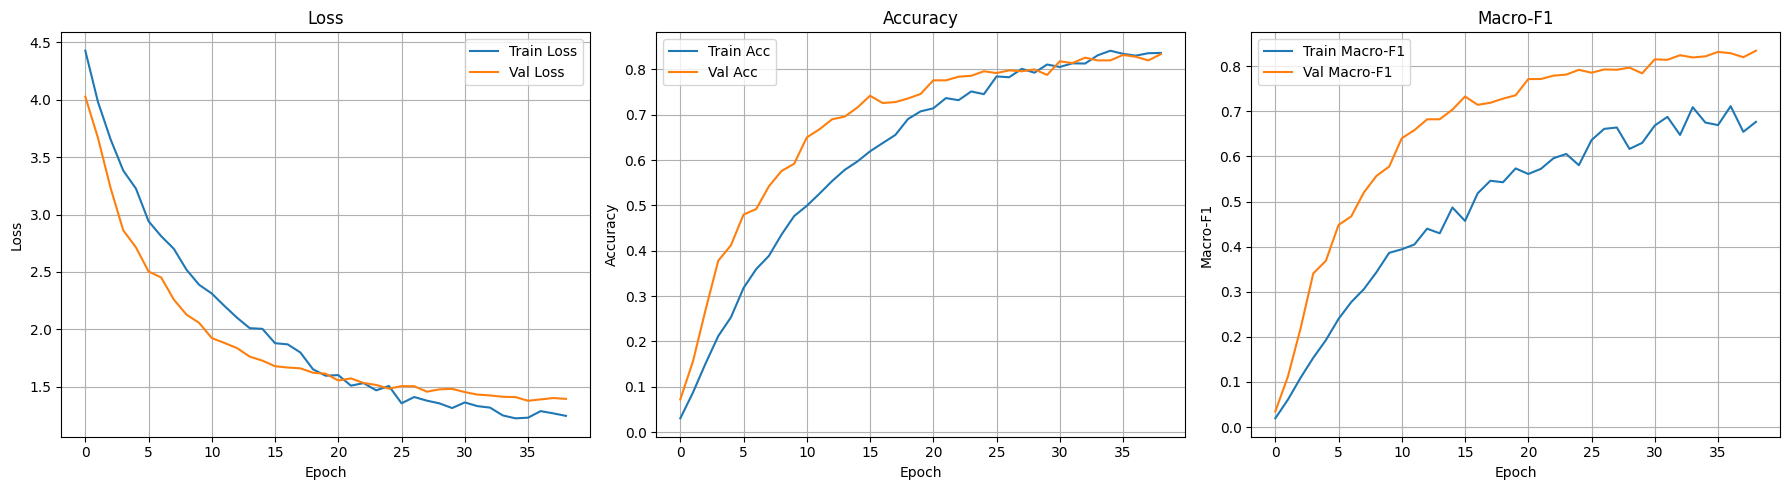

In [15]:
plot_history(history)

In [16]:
test_ds, test_loader = build_test_loader(cfg, device)

test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, device)

print("-" * 30)
print(f"Test Set Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Set Macro F1: {test_f1:.4f}")
print("-" * 30)

Test samples found: 500
Classes found: 100
------------------------------
Test Set Accuracy: 0.8440 (84.40%)
Test Set Macro F1: 0.8337
------------------------------


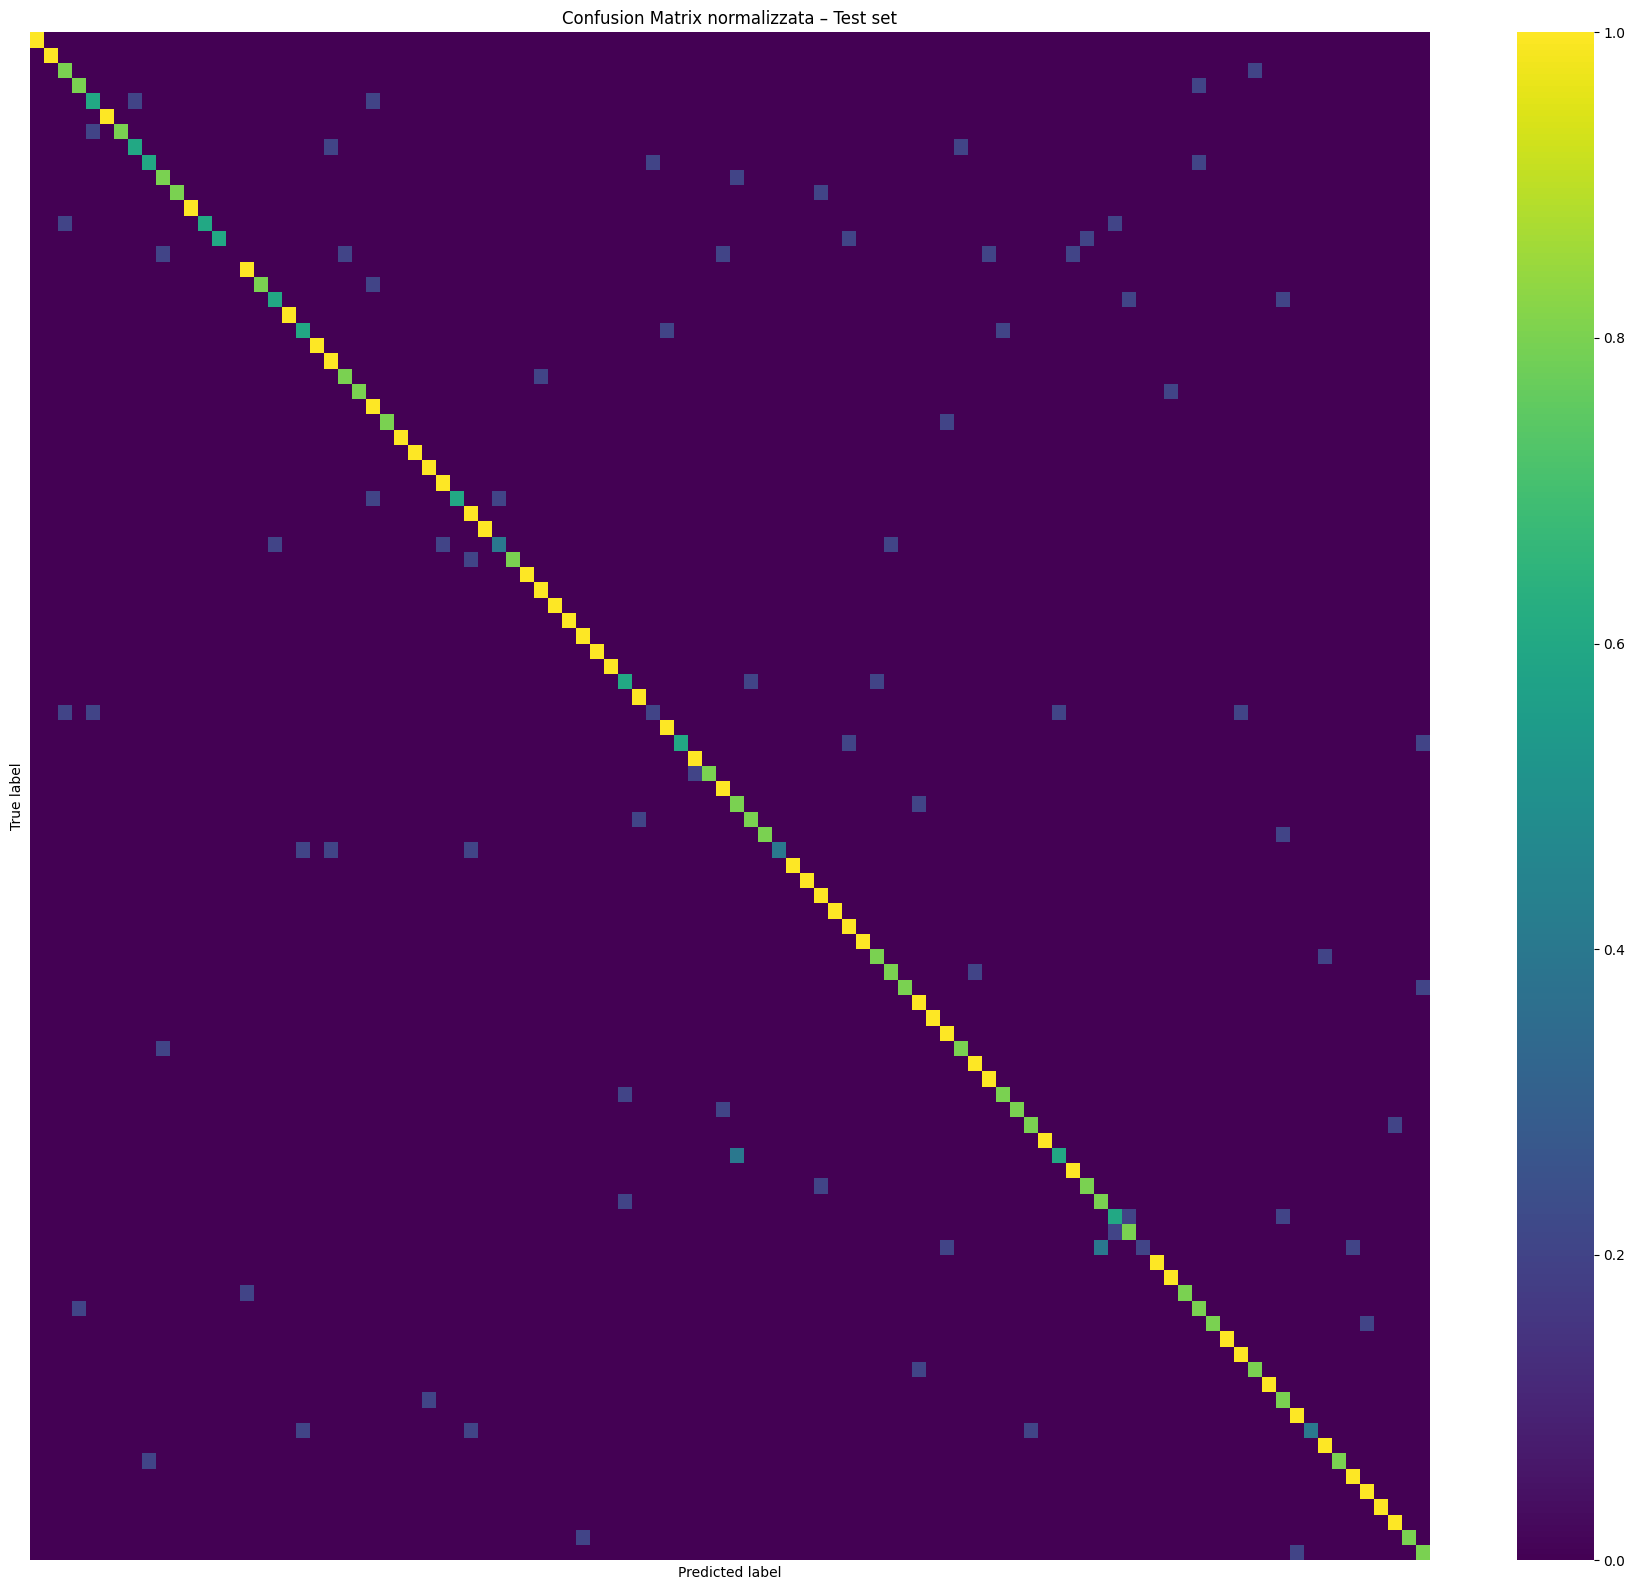

In [17]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, title="Confusion Matrix normalizzata – Test set")

In [18]:
print_top_confusions(cm, test_ds.classes, top_k=100)


Top 100 coppie più confuse:

shot put → javelin  | 2 errori
snow boarding → ski jumping  | 2 errori
archery → tennis  | 1 errori
arm wrestling → sumo wrestling  | 1 errori
axe throwing → baseball  | 1 errori
axe throwing → disc golf  | 1 errori
barell racing → axe throwing  | 1 errori
baseball → cricket  | 1 errori
baseball → rings  | 1 errori
basketball → horseshoe pitching  | 1 errori
basketball → sumo wrestling  | 1 errori
baton twirling → javelin  | 1 errori
bike polo → motorcycle racing  | 1 errori
bmx → archery  | 1 errori
bmx → sky surfing  | 1 errori
bobsled → nascar racing  | 1 errori
bobsled → sidecar racing  | 1 errori
bowling → baton twirling  | 1 errori
bowling → croquet  | 1 errori
bowling → jai alai  | 1 errori
bowling → roller derby  | 1 errori
bowling → shuffleboard  | 1 errori
bull riding → disc golf  | 1 errori
bungee jumping → skydiving  | 1 errori
bungee jumping → trapeze  | 1 errori
cheerleading → hurdles  | 1 errori
cheerleading → rollerblade racing  | 1 errori
